In [2]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

In [3]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils

import shap
import matplotlib.pyplot as plt
import pickle 
import joblib
from joblib import load


import macaw
print(macaw.__version__)
from macaw import *

1.0.1


### Define directories

In [4]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')

### Extract the data for `Ebola` into a data frame with `duplicate` SMILES

In [5]:
EbolavirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "EbolaVirusData_chEMBL_wMACAW.csv")
EbolavirusData_chEMBL_wMACAW

,ID,compound_id,Smiles,pPotency,VirusClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,3,CHEMBL4751715,CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...,5.725842,Ebola,0.094048,-0.001439,-0.073435,-0.065056,0.027846,-0.027750,0.050309,-0.075393,0.088900,-0.081788,0.265140,-0.127500,-0.157573,-0.047385,-0.103447
1,4,CHEMBL4792617,CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...,5.603801,Ebola,0.105030,0.022220,-0.061948,-0.059114,0.014670,-0.037607,0.078092,-0.117133,0.079593,-0.066911,0.267439,-0.146161,-0.210740,-0.052019,-0.124606
2,8,CHEMBL5084473,CCC(CC)COC(=O)[C@@H](C)N[P@](=O)(OC[C@H]1O[C@@...,6.080922,Ebola,0.296270,0.105519,0.038865,0.025880,-0.013126,-0.036065,0.081546,-0.063053,0.021286,0.019768,0.142351,-0.094990,-0.015843,-0.049119,-0.076832
3,9,CHEMBL2323050,N#Cc1ccc(CN2CCN(C(=O)CNC(=O)CC34CC5CC(CC(C5)C3...,5.096910,Ebola,-0.211000,0.200560,0.101905,0.064365,-0.080054,0.049137,-0.069135,0.222683,0.006978,0.004083,0.003098,-0.001698,-0.089829,0.002428,0.010749
4,10,CHEMBL2323047,COc1ccc(CN2CCN(C(=O)CNC(=O)CC34CC5CC(CC(C5)C3)...,5.267606,Ebola,-0.233701,0.202773,0.100234,0.024098,-0.065622,0.046678,-0.076074,0.224464,0.002351,-0.004631,0.018453,0.011070,-0.079583,0.020837,-0.009411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,720,CHEMBL5590446,CC1(C)[C@H]2CC[C@](C)(C2)[C@H]1OC(=O)CCCN1CCCCC1,5.494850,Ebola,-0.132394,-0.080510,0.313293,-0.059479,0.056014,0.187630,-0.068829,-0.142991,0.050951,0.086354,0.064244,0.014854,-0.064376,-0.109818,0.036707
643,721,CHEMBL5594689,CC1(C)[C@@H]2CC[C@@]1(CS(=O)(=O)N1CCOCC1)C(=O)C2,6.045757,Ebola,-0.127886,-0.094903,0.238268,-0.021451,0.025724,0.146530,-0.034298,-0.122028,0.014102,0.074629,0.013174,0.014636,-0.129618,-0.292320,0.126789
644,722,CHEMBL5591747,CCN1CCN(CCCC(=O)O[C@H]2C(C)(C)[C@H]3CC[C@]2(C)...,5.275724,Ebola,-0.122412,-0.055456,0.283845,-0.070327,0.053367,0.168142,-0.043390,-0.119571,0.043821,0.082045,0.026786,0.015281,-0.067764,-0.099425,0.037267
645,724,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.208450,Ebola,-0.071237,-0.164895,0.056582,0.033250,-0.095569,0.074862,0.002924,-0.041271,0.011122,-0.056664,-0.037499,-0.038531,-0.093068,-0.052730,-0.013498


In [6]:
ZaireEbolavirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "ZaireEbolavirusData_chEMBL_wMACAW.csv")
ZaireEbolavirusData_chEMBL_wMACAW

,ID,compound_id,Smiles,pPotency,StrainClassifier,pPotency_category,MACAW_1,MACAW_2,MACAW_3,MACAW_4,...,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,1,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.173925,ZaireEbola,3-10,-0.597267,0.203766,0.080453,0.214558,...,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
1,2,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.173925,ZaireEbola,3-10,-0.597267,0.203766,0.080453,0.214558,...,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
2,3,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.619789,ZaireEbola,3-10,-0.597267,0.203766,0.080453,0.214558,...,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
3,4,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.619789,ZaireEbola,3-10,-0.597267,0.203766,0.080453,0.214558,...,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
4,5,CHEMBL5611967,O=C(Nc1cccc(Cl)c1)c1ccc(-c2cccc(OC3CCNCC3)c2)s1,5.730487,ZaireEbola,3-10,0.194000,0.271922,0.028860,0.008549,...,0.004466,-0.010283,0.023163,0.044987,0.174677,0.079320,0.070356,-0.031430,-0.032638,0.182068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,131,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,3-10,0.002611,-0.102177,-0.327227,0.065414,...,0.093176,0.087306,-0.061251,-0.043842,0.074410,0.026748,0.084964,-0.171084,-0.026267,-0.080352
131,132,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,3-10,0.002611,-0.102177,-0.327227,0.065414,...,0.093176,0.087306,-0.061251,-0.043842,0.074410,0.026748,0.084964,-0.171084,-0.026267,-0.080352
132,133,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,3-10,-0.027520,-0.131712,-0.412087,-0.021914,...,0.138736,0.089382,-0.111563,0.007607,0.086831,-0.007486,0.114860,-0.183397,-0.088811,-0.045560
133,134,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,3-10,-0.027520,-0.131712,-0.412087,-0.021914,...,0.138736,0.089382,-0.111563,0.007607,0.086831,-0.007486,0.114860,-0.183397,-0.088811,-0.045560


In [7]:
ZaireEbolavirusData_chEMBL_wMACAW = ZaireEbolavirusData_chEMBL_wMACAW.drop('pPotency_category', axis=1)
ZaireEbolavirusData_chEMBL_wMACAW = ZaireEbolavirusData_chEMBL_wMACAW.rename(columns={'StrainClassifier': 'VirusClassifier'})
ZaireEbolavirusData_chEMBL_wMACAW

,ID,compound_id,Smiles,pPotency,VirusClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,1,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.173925,ZaireEbola,-0.597267,0.203766,0.080453,0.214558,-0.148606,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
1,2,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.173925,ZaireEbola,-0.597267,0.203766,0.080453,0.214558,-0.148606,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
2,3,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.619789,ZaireEbola,-0.597267,0.203766,0.080453,0.214558,-0.148606,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
3,4,CHEMBL221722,NC(=O)c1nc(F)cnc1O,4.619789,ZaireEbola,-0.597267,0.203766,0.080453,0.214558,-0.148606,0.115450,-0.216024,0.024546,-0.000042,-0.013658,-0.051793,0.042074,-0.001572,0.024070,-0.018438
4,5,CHEMBL5611967,O=C(Nc1cccc(Cl)c1)c1ccc(-c2cccc(OC3CCNCC3)c2)s1,5.730487,ZaireEbola,0.194000,0.271922,0.028860,0.008549,0.042854,0.004466,-0.010283,0.023163,0.044987,0.174677,0.079320,0.070356,-0.031430,-0.032638,0.182068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,131,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,0.002611,-0.102177,-0.327227,0.065414,-0.083172,0.093176,0.087306,-0.061251,-0.043842,0.074410,0.026748,0.084964,-0.171084,-0.026267,-0.080352
131,132,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,0.002611,-0.102177,-0.327227,0.065414,-0.083172,0.093176,0.087306,-0.061251,-0.043842,0.074410,0.026748,0.084964,-0.171084,-0.026267,-0.080352
132,133,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,-0.027520,-0.131712,-0.412087,-0.021914,-0.186133,0.138736,0.089382,-0.111563,0.007607,0.086831,-0.007486,0.114860,-0.183397,-0.088811,-0.045560
133,134,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,-0.027520,-0.131712,-0.412087,-0.021914,-0.186133,0.138736,0.089382,-0.111563,0.007607,0.086831,-0.007486,0.114860,-0.183397,-0.088811,-0.045560


In [8]:
combinedEbolaVirusData_chEMBL_wMACAW = pd.concat([EbolavirusData_chEMBL_wMACAW, ZaireEbolavirusData_chEMBL_wMACAW], axis=0)
combinedEbolaVirusData_chEMBL_wMACAW

,ID,compound_id,Smiles,pPotency,VirusClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,3,CHEMBL4751715,CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...,5.725842,Ebola,0.094048,-0.001439,-0.073435,-0.065056,0.027846,-0.027750,0.050309,-0.075393,0.088900,-0.081788,0.265140,-0.127500,-0.157573,-0.047385,-0.103447
1,4,CHEMBL4792617,CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...,5.603801,Ebola,0.105030,0.022220,-0.061948,-0.059114,0.014670,-0.037607,0.078092,-0.117133,0.079593,-0.066911,0.267439,-0.146161,-0.210740,-0.052019,-0.124606
2,8,CHEMBL5084473,CCC(CC)COC(=O)[C@@H](C)N[P@](=O)(OC[C@H]1O[C@@...,6.080922,Ebola,0.296270,0.105519,0.038865,0.025880,-0.013126,-0.036065,0.081546,-0.063053,0.021286,0.019768,0.142351,-0.094990,-0.015843,-0.049119,-0.076832
3,9,CHEMBL2323050,N#Cc1ccc(CN2CCN(C(=O)CNC(=O)CC34CC5CC(CC(C5)C3...,5.096910,Ebola,-0.211000,0.200560,0.101905,0.064365,-0.080054,0.049137,-0.069135,0.222683,0.006978,0.004083,0.003098,-0.001698,-0.089829,0.002428,0.010749
4,10,CHEMBL2323047,COc1ccc(CN2CCN(C(=O)CNC(=O)CC34CC5CC(CC(C5)C3)...,5.267606,Ebola,-0.233701,0.202773,0.100234,0.024098,-0.065622,0.046678,-0.076074,0.224464,0.002351,-0.004631,0.018453,0.011070,-0.079583,0.020837,-0.009411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,131,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,0.002611,-0.102177,-0.327227,0.065414,-0.083172,0.093176,0.087306,-0.061251,-0.043842,0.074410,0.026748,0.084964,-0.171084,-0.026267,-0.080352
131,132,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,0.002611,-0.102177,-0.327227,0.065414,-0.083172,0.093176,0.087306,-0.061251,-0.043842,0.074410,0.026748,0.084964,-0.171084,-0.026267,-0.080352
132,133,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,-0.027520,-0.131712,-0.412087,-0.021914,-0.186133,0.138736,0.089382,-0.111563,0.007607,0.086831,-0.007486,0.114860,-0.183397,-0.088811,-0.045560
133,134,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,-0.027520,-0.131712,-0.412087,-0.021914,-0.186133,0.138736,0.089382,-0.111563,0.007607,0.086831,-0.007486,0.114860,-0.183397,-0.088811,-0.045560


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

Find Features and Response

In [10]:
input_var = [col for col in combinedEbolaVirusData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(input_var)

['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [9]:
features = combinedEbolaVirusData_chEMBL_wMACAW[input_var].to_numpy()

In [10]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [11]:
response = combinedEbolaVirusData_chEMBL_wMACAW[response_var].to_numpy()

And then save the data as a EDD style file (see "Importing a Study" here):

In [12]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'combinedEbolaVirusData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [13]:
combinedEbolaVirusData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "combinedEbolaVirusData_chEMBL_wMACAW_ARTready.csv")
combinedEbolaVirusData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,0.094048
1,1,MACAW_1,0.105030
2,2,MACAW_1,0.296270
3,3,MACAW_1,-0.211000
4,4,MACAW_1,-0.233701
...,...,...,...
12507,777,pPotency,6.283997
12508,778,pPotency,6.283997
12509,779,pPotency,5.721246
12510,780,pPotency,5.721246


Let's now define the ART parameters needed for the prediction of production

In [9]:
artResultDir = resultsDir + 'ART_results/Ebola'
os.makedirs(artResultDir, exist_ok=True)

In [15]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    # Uncomment this to avoid a random seed
    'output_dir': artResultDir,
}

And then run ART without recommendations but with cross-validations to gauge how generalizable the results are:

ART identified 782 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_

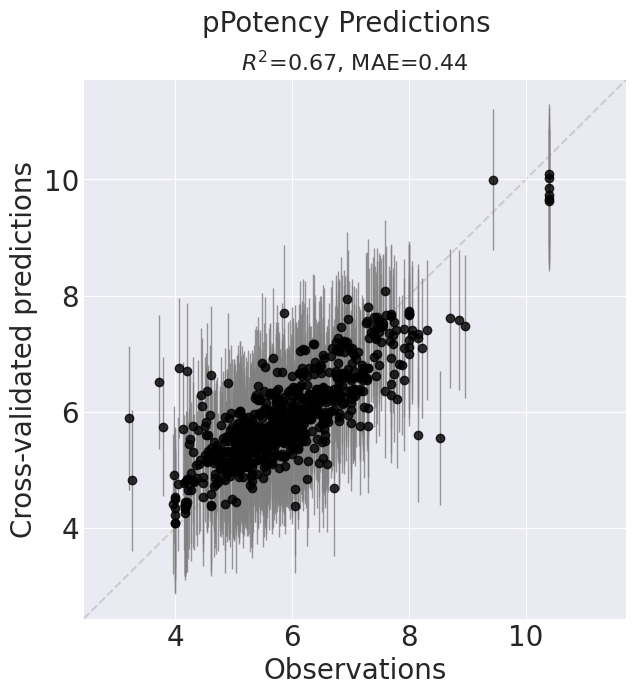

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor


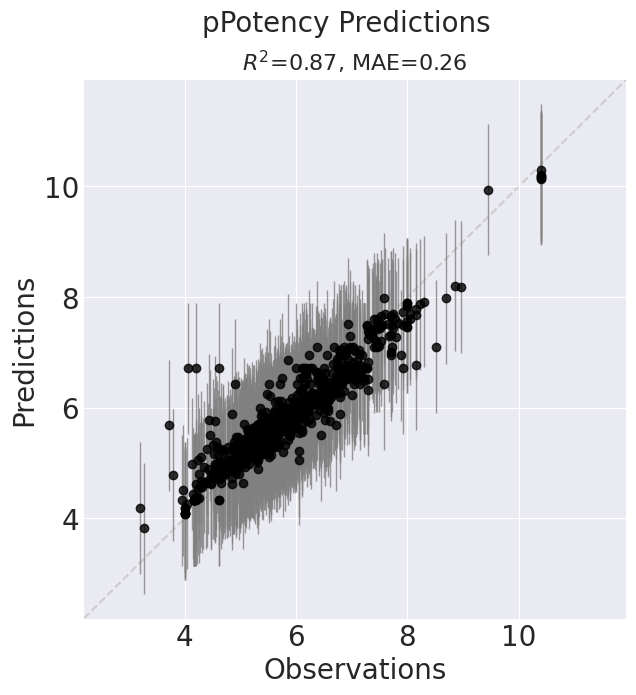

CPU times: user 21min 19s, sys: 15.9 s, total: 21min 34s
Wall time: 2h 37min 18s


In [16]:
%%time

art = RecommendationEngine(df=combinedEbolaVirusData_chEMBL_wMACAW_ARTready, **art_params,recommend=False,cross_val=True)

In [28]:
# ========== LOAD ART MODEL ==========
print("Loading ART model...")
ARTtrainedModelFile = artResultDir + '/art.cpkl'  
with open(ARTtrainedModelFile, 'rb') as f:
    art_model = pickle.load(f)

export_dir = artResultDir + '/exportedARTmodels'
os.makedirs(export_dir, exist_ok=True)

# ========== EXTRACT L0 MODELS FROM model_dfs ==========
print("\nExtracting L0 models from model_dfs...")
l0_learners = art_model.l0_learners

# L0 models are stored in model_dfs
if hasattr(l0_learners, 'model_dfs'):
    model_dfs = l0_learners.model_dfs
    print(f"Found {len(model_dfs)} model dataframes")
    
    # Extract sklearn models from dataframes
    l0_models = []
    for i, df in enumerate(model_dfs):
        if 'model' in df.columns:
            # Get the trained model from the dataframe
            model = df['model'].iloc[0]  # Usually the best model
            l0_models.append(model)
            
            # Save individual L0 model
            l0_filepath = os.path.join(export_dir, f'l0_model_{i}.joblib')
            try:
                joblib.dump(model, l0_filepath)
                print(f"   Saved L0 model {i}: {type(model).__name__}")
            except Exception as e:
                print(f"   Could not save L0 model {i}: {e}")
    
    print(f"\nTotal L0 models extracted: {len(l0_models)}")
else:
    print("Warning: model_dfs not found")
    l0_models = []

# ========== CREATE PREDICTION FUNCTION USING ART ==========
print("\nGenerating predictions on training data using ART...")

# Get training data
X_train = art_model.X
y_train = art_model.y
input_features = art_model.input_vars

# Generate predictions using ART's predict method
y_train_pred = art_model.predict(X_train)

print(f"Training predictions shape: {y_train_pred.shape}")

# ========== CREATE SURROGATE MODEL ==========
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

print("\nCreating surrogate Random Forest model...")
surrogate_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

surrogate_model.fit(X_train, y_train_pred.ravel())  # Use ravel() to flatten

# Evaluate surrogate fidelity
y_surrogate_pred = surrogate_model.predict(X_train)
surrogate_r2 = r2_score(y_train_pred, y_surrogate_pred)
surrogate_mae = mean_absolute_error(y_train_pred, y_surrogate_pred)

print(f"Surrogate model fidelity:")
print(f"  R² vs ART predictions: {surrogate_r2:.4f}")
print(f"  MAE vs ART predictions: {surrogate_mae:.4f}")

# Save surrogate model
surrogate_file = os.path.join(export_dir, 'surrogate_model.joblib')
joblib.dump(surrogate_model, surrogate_file)
print(f"\n Saved surrogate model: {surrogate_file}")

# ========== SAVE TRAINING PREDICTIONS LOOKUP ==========
training_lookup = pd.DataFrame(X_train, columns=input_features)
training_lookup['ART_prediction'] = y_train_pred.ravel()
training_lookup['true_value'] = y_train.ravel()

lookup_file = os.path.join(export_dir, 'training_predictions_lookup.csv')
training_lookup.to_csv(lookup_file, index=False)
print(f" Saved training predictions lookup: {lookup_file}")

# ========== SAVE METADATA ==========
metadata = {
    'model_type': 'ART Ensemble with Surrogate',
    'num_l0_models': len(l0_models),
    'l0_model_types': [type(m).__name__ for m in l0_models],
    'input_features': input_features,
    'target_variable': art_model.response_vars,
    'num_obs': art_model.num_obs,
    'surrogate_fidelity_r2': float(surrogate_r2),
    'surrogate_fidelity_mae': float(surrogate_mae),
    'training_data_shape': X_train.shape,
    'art_file_location': str(ARTtrainedModelFile),
}

metadata_file = os.path.join(export_dir, 'metadata.pkl')
with open(metadata_file, 'wb') as f:
    pickle.dump(metadata, f)
print(f" Saved metadata: {metadata_file}")

# ========== CREATE COMPREHENSIVE EXPORT PACKAGE ==========
export_package = {
    'surrogate_model': surrogate_model,
    'l0_models': l0_models if len(l0_models) > 0 else None,
    'input_features': input_features,
    'metadata': metadata,
    'training_data': {
        'X': X_train,
        'y': y_train.ravel(),
        'y_art_pred': y_train_pred.ravel(),
    }
}

package_file = os.path.join(export_dir, 'art_export_package.joblib')
joblib.dump(export_package, package_file)
print(f" Saved complete package: {package_file}")

# ========== SUMMARY ==========
print("\n" + "="*70)
print("EXPORT SUMMARY")
print("="*70)
print(f"Export directory: {export_dir}")
print(f"\nFiles created:")
print(f"  1. surrogate_model.joblib")
print(f"     - Type: {type(surrogate_model).__name__}")
print(f"     - Fidelity R²: {surrogate_r2:.4f}")
print(f"     - Fidelity MAE: {surrogate_mae:.4f}")
print(f"  2. training_predictions_lookup.csv ({len(training_lookup)} samples)")
print(f"  3. art_export_package.joblib (complete package)")
print(f"  4. metadata.pkl")
if len(l0_models) > 0:
    print(f"  5. {len(l0_models)} L0 model file(s)")
print(f"\nInput features ({len(input_features)}): {input_features}")
print(f"Training samples: {X_train.shape[0]}")
print("\n Export completed successfully!")

# ========== QUICK TEST ==========
print("\nQuick test of surrogate model...")
test_idx = np.random.choice(len(X_train), 5, replace=False)
X_test = X_train[test_idx]
y_art_test = y_train_pred[test_idx]
y_surrogate_test = surrogate_model.predict(X_test)

print("\nComparison (5 random samples):")
print(f"{'ART Prediction':<20} {'Surrogate Prediction':<20} {'Difference':<15}")
print("-" * 55)
for art_val, surr_val in zip(y_art_test.ravel(), y_surrogate_test):
    diff = abs(art_val - surr_val)
    print(f"{art_val:<20.4f} {surr_val:<20.4f} {diff:<15.4f}")

Loading ART model...

Extracting L0 models from model_dfs...
Found 1 model dataframes

Total L0 models extracted: 0

Generating predictions on training data using ART...
Training predictions shape: (782, 1)

Creating surrogate Random Forest model...
Surrogate model fidelity:
  R² vs ART predictions: 0.9882
  MAE vs ART predictions: 0.0596

 Saved surrogate model: /code/DTRA_ART/DrugDesignData/Results/ART_results/Ebola/exportedARTmodels/surrogate_model.joblib
 Saved training predictions lookup: /code/DTRA_ART/DrugDesignData/Results/ART_results/Ebola/exportedARTmodels/training_predictions_lookup.csv
 Saved metadata: /code/DTRA_ART/DrugDesignData/Results/ART_results/Ebola/exportedARTmodels/metadata.pkl
 Saved complete package: /code/DTRA_ART/DrugDesignData/Results/ART_results/Ebola/exportedARTmodels/art_export_package.joblib

EXPORT SUMMARY
Export directory: /code/DTRA_ART/DrugDesignData/Results/ART_results/Ebola/exportedARTmodels

Files created:
  1. surrogate_model.joblib
     - Type: R

### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [17]:
shap.initjs()

In [18]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [19]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [20]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [21]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

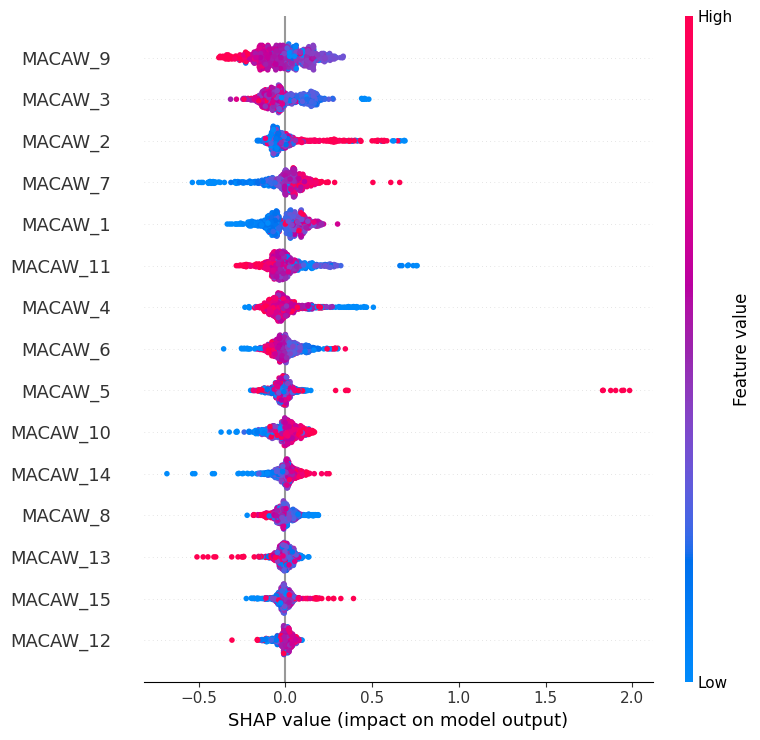

In [22]:
shap.summary_plot(shap_values_e)

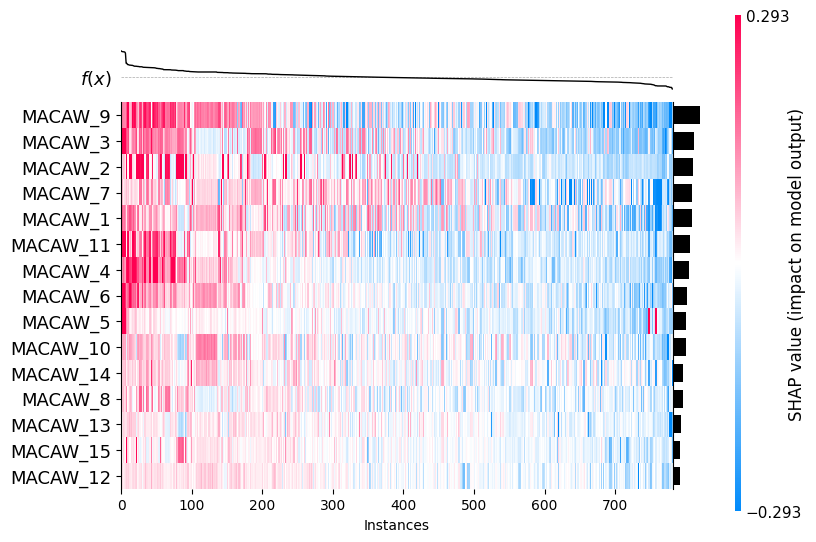

<Axes: xlabel='Instances'>

In [23]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [10]:
EnamineAntiviralsData = pd.read_csv(dataDir + "Enamine/Enamine_Antiviral_Library_plated_3200cmpds_20251019.csv",
                                    sep=",", comment=None, skipinitialspace=True, engine="python", encoding="utf-8",          
                                    skiprows=1, skip_blank_lines=True)
print(f"Original Enamine data shape: {EnamineAntiviralsData.shape}")

smiles_train = combinedEbolaVirusData_chEMBL_wMACAW.Smiles

# Function to canonicalize SMILES using RDKit
def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            return Chem.MolToSmiles(mol, canonical=True)
        else:
            return None
    except:
        return None

# Canonicalize training SMILES and create a set for fast lookup
canonical_train = set()
for smi in smiles_train:
    canonical_smi = canonicalize_smiles(smi)
    if canonical_smi is not None:
        canonical_train.add(canonical_smi)

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to Enamine data
EnamineAntiviralsData['Canonical_SMILES'] = EnamineAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~EnamineAntiviralsData['Canonical_SMILES'].isin(canonical_train)
EnamineAntiviralsData_filtered = EnamineAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
EnamineAntiviralsData = EnamineAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered Enamine data shape for validation: {EnamineAntiviralsData.shape}")
print(f"Removed {EnamineAntiviralsData.shape[0] - EnamineAntiviralsData_filtered.shape[0]} duplicate compounds from Enamine data set")

# Now use the filtered data
smi_lib = EnamineAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
EnamineAntiviralsData.head()

Original Enamine data shape: (3200, 11)
Number of unique SMILES in training set: 510
Filtered Enamine data shape for validation: (3200, 11)
Removed 0 duplicate compounds from Enamine data set
Total compounds to screen: 3200


,SMILES,Catalog ID,MW,MW (desalted),ClogP,logS,HBD,HBA,TPSA,RotBonds,AnalogsFromREAL
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,Z410227912,256.326,256.326,1.231,-2.190,2,4,76.14,5,https://real.enamine.net/public-enum-files/Z41...
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,Z383167688,237.256,237.256,-0.042,-0.692,1,3,69.72,5,https://real.enamine.net/public-enum-files/Z38...
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,Z235579208,306.404,306.404,1.583,-2.082,1,5,57.70,7,NaN
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,Z403694008,279.379,279.379,1.156,-0.660,1,3,58.37,7,https://real.enamine.net/public-enum-files/Z40...
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,Z384461492,307.389,307.389,1.084,-1.180,1,4,61.88,7,https://real.enamine.net/public-enum-files/Z38...


Load MACAW transformer

In [11]:
from joblib import load

macaw_file_path = os.path.join(modelBuildingDataDir, "combinedEbolaVirusData_chEMBL_MACAW_transformer.joblib")
mcw = load(macaw_file_path)
print(f" MACAW transformer loaded from: {macaw_file_path}")

 MACAW transformer loaded from: /code/DTRA_ART/DrugDesignData/modelBuildingData/combinedEbolaVirusData_chEMBL_MACAW_transformer.joblib


Load pre-trained ART model

In [12]:
ARTtrainedModelFile = os.path.join(artResultDir, 'art.cpkl')
with open(ARTtrainedModelFile, 'rb') as f:
    regr_pred = pickle.load(f)
print(f" ART model loaded from: {ARTtrainedModelFile}")

ModuleNotFoundError: No module named 'numpy._core.numeric'

In [59]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

Get predictions with uncertainty using ART's post_pred_stats

In [60]:
# Pass X1_lib (features)
mean, std = regr_pred.post_pred_stats(X1_lib)

# Now use these for your results
EnamineAntiviralsData_predicted = EnamineAntiviralsData.copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = mean
EnamineAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_upper_95CI'])
EnamineAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_EnamineDatasets_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_EnamineDatasets_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiviralsData_predicted

Predictions saved with uncertainty estimates!


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,5.325195,0.605085,4.139228,6.511162,0.000005,3.082041e-07,0.000073
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,5.490288,0.605247,4.304003,6.676572,0.000003,2.105854e-07,0.000050
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,5.475778,0.606045,4.287929,6.663627,0.000003,2.169567e-07,0.000052
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,5.431068,0.605988,4.243332,6.618804,0.000004,2.405446e-07,0.000057
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,5.437308,0.606657,4.248260,6.626355,0.000004,2.363984e-07,0.000056
...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,5.428139,0.606081,4.240221,6.616057,0.000004,2.420711e-07,0.000058
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,5.566602,0.605849,4.379138,6.754066,0.000003,1.761710e-07,0.000042
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,5.330305,0.605579,4.143371,6.517239,0.000005,3.039210e-07,0.000072
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,5.268197,0.605104,4.082194,6.454201,0.000005,3.513977e-07,0.000083


Let us represent the predictions of both models

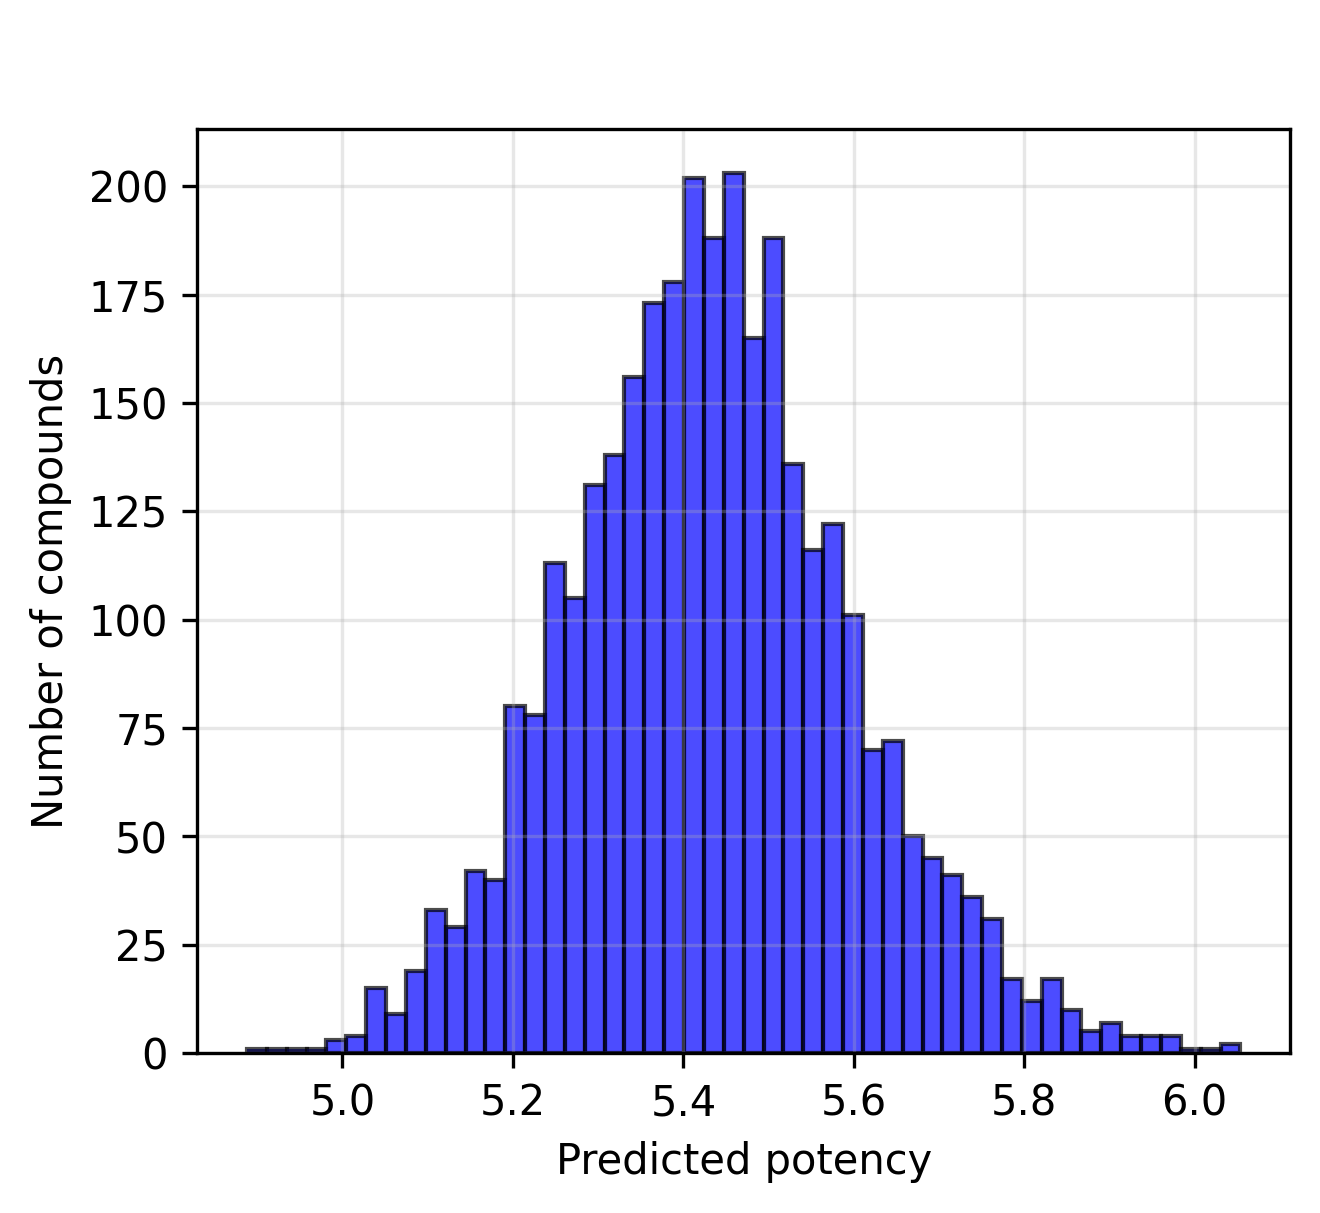

In [61]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_validation.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_validation.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [62]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7.0)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

High priority (pPotency ≥ 7.0): 0 compounds
Medium priority (6 ≤ pPotency < 7.0): 4 compounds
Low priority (5 ≤ pPotency < 6): 3190 compounds


### Top 20 compounds with higher pPotency

In [69]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
Y1_lib_pred = Y1_lib_pred.flatten() 
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

Top 20 compounds cutoff pPotency: 5.90
Highest predicted pPotency: 6.05
Range of top 20: 5.90 - 6.05


In [70]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
EnamineAntiviralsData_top20 = EnamineAntiviralsData.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
EnamineAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
EnamineAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
EnamineAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
EnamineAntiviralsData_top20 = EnamineAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
EnamineAntiviralsData_top20

----------------------------------------------------------------------
Top 20 Compounds with Highest Predicted pPotency
----------------------------------------------------------------------

Cutoff Values (20th ranked compound):
  pPotency:    5.899
  IC50:        1.262e-06 M  (1261.51 nM)

Best Values (1st ranked compound):
  pPotency:    6.054
  IC50:        8.839e-07 M  (883.91 nM)
Range for Top 20 Compounds:
pPotency Range:  5.899 - 6.054

IC50 Range (M):  1.262e-06 - 8.839e-07


,Rank,SMILES,pPotency_prediction,IC50 (M)
1732,1,CC(=O)NCCC1=NC=2C=CC=CC2N1CCOC=3C=CC(C)=CC3,6.054,8.839e-07
999,2,CC(=O)NCCC1=NC=2C=CC=CC2N1CCOC3=CC=CC(C)=C3,6.053,8.857e-07
173,3,CCCNC(=O)C(C)NC(=O)CN1N=C(C)C(C)=C(C#N)C1=O,6.015,9.665e-07
1027,4,COCCN1C(=NC2=C1C(=O)NC(=O)N2C)N(C)CC=3C=CC=CC3,6.001,9.988e-07
2021,5,CC=1C=CC(C)=C(C1)OCCN2C(CNC=O)=NC3=CC=CC=C32,5.981,1.044e-06
958,6,CCC(C)(CNC(=O)CN1C=CC(=O)N(C)C1=O)N2CCOCC2,5.980,1.048e-06
1308,7,COCCN1C=C(C=CC1=O)NC(=O)C2C(C=C(C)C)C2(C)C,5.978,1.052e-06
819,8,CC(C)C(C)NC(=O)CN1C(=O)C(=CC=C1C(F)(F)F)C(N)=O,5.969,1.074e-06
813,9,COCCN1C(=O)NC(=O)C(NCC=2C=CC=CC2)=C1NC(C)=O,5.960,1.096e-06
456,10,CN(C)S(=O)(=O)C=1C=CC(=O)N(C1)CC(=O)NC(=O)NC2CC2,5.958,1.102e-06


In [71]:
EnamineAntiviralsData_top20.to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_EnamineAntiviralsData_top20.csv"), index=False)
EnamineAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "combinedEbolaVirus/combinedEbolaVirus_wART_EnamineAntiviralsData_top20_SMILES.csv"), index=False)

In [91]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from PIL import Image


# Get molecules
molecules = [Chem.MolFromSmiles(smi) for smi in EnamineAntiviralsData_top20.SMILES[:50]]

# Create legends
legends = []
for idx, row in EnamineAntiviralsData_top20[:50].iterrows():
    legend = f"pIC50: {row['pPotency_prediction']:.3f}\nIC50: {row['IC50 (M)']:.2e} M"
    legends.append(legend)

# Generate PNG image
img = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=False, 
    legends=legends,
    returnPNG=False  # Returns PIL Image object
)

# Save PNG
output_png = resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_enamine_predictedCompounds.png'
img.save(output_png, dpi=(600, 600))
print(f" Saved PNG: {output_png}")

# Generate and save SVG
svg = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=True,
    legends=legends
)

output_svg = resultsDir + 'combinedEbolaVirus/combinedEbolaVirus_wART_enamine_predictedCompounds.svg'
with open(output_svg, 'w') as f:
    f.write(svg.data)
print(f" Saved SVG: {output_svg}")


display(img)  

ImportError: libXrender.so.1: cannot open shared object file: No such file or directory

### Extract the data for `Ebola` into a data frame without `duplicate` SMILES

In [ ]:
EbolaVirusData_chEMBL_noDuplicates = pd.read_csv(modelBuildingDataDir + "EbolaVirusData_chEMBL_wMACAW_noDuplicates_MLready.csv")
EbolaVirusData_chEMBL_noDuplicates

### Prepare to run `ART` on `Ebola` data without `duplicate` SMILES